In [1]:
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation
from keras.layers import Dropout, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import SGD
from keras.utils import to_categorical
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

b:\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# This function retrieves the previous 4 days given a single day for input from the .csv file.
def getEvalData(nparray,date,predict_delta):
    res = [[]]
    idx = np.argwhere(nparray==date)[0][0] - 4
    # if the given date does not have 5 previous values...
    if idx < 4 or idx + 7 > nparray.shape[0]:
        return
    else:
        for i in range(5):
            res[0].append(nparray[i+idx][1])
        # the day we are predicting is t
        predict_day = nparray[4+idx+predict_delta][1]
        predict_day_percent = (predict_day - res[0][4])/predict_day
         # putting y-values into the correct bucket
        if predict_day_percent >= .03:
            res.append(np.array([1, 0, 0]))

        elif predict_day_percent > -.03 and predict_day_percent < .03:
            res.append(np.array([0, 1, 0]))

        else:
            res.append(np.array([0, 0, 1]))
        res.append(predict_day)
    return res
        

In [3]:
# Trying to convert the input data, which starts off as dataframeX, must take 5 days and then transpose it
# and then convert it into a numpy array

rawdata = pd.read_csv('data/bitcoin.csv',usecols=[8])
days = 5                                                      # Number of days we are looking at
predict_delta = 7                                             # Number of days we are predicting into the future 
number_of_items = rawdata.shape[0] - (predict_delta + days)   # number of tests
# size of our test 
test_size = number_of_items - 733

# five day blocks in a list
Xtrain = []    
# the values of the day we are trying to predict
Ytrain = []                                                   



# Splits the array of closing prices up into multiple arrays, each holding five days worth of prices
# then transposes each array and finally appends them onto one large matrix
countup = 0
counteven = 0
countdown = 0
for i in range(number_of_items - 200): 
    # finding the predict day
    predict = rawdata.head(days + i + predict_delta).tail(1).as_matrix().transpose().tolist()[0][0]
    last_day = rawdata.head(days + i).tail(1).as_matrix().transpose().tolist()[0][0]
    # Converting and adding data to arrays
    res = rawdata.head(days + i).tail(days).as_matrix().transpose().tolist()[0]
    Xtrain.append(res)
    y_val = (predict - last_day)/predict
    
    if y_val >= .03:
        countup = countup + 1
        # a value of [ 1 0 0 ] represents that it will increase by 3% in a week
        Ytrain.append(np.array([1, 0, 0]))
        
    elif y_val > -.03 and y_val < .03:
        counteven = counteven + 1
        # a value of [ 0 1 0 ] represents that the value will stay within 3%
        Ytrain.append(np.array([0, 1, 0]))
        
    else:
        countdown = countdown + 1
        # a value of [ 0 0 1] represents a value that will decrease by 3%
        Ytrain.append(np.array([0, 0, 1]))
        
    
print(countup)
print(counteven)
print(countdown)
# converts python arrays into numpy arrays
Xtrain = np.array(Xtrain)
Ytrain = np.array(Ytrain)
#print(Xtrain)
#print(Ytrain)

576
518
439


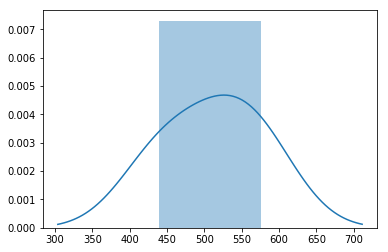

In [6]:
# This cell is being used to visualize the "buckets"
histo_data = np.array([countup,counteven,countdown])
points = np.array([1,2,3])
sns.distplot(histo_data, bins=3)
plt.show()


In [4]:
# number of evalutaion data points
eval_size = number_of_items - 200

# evaluation input data
XEvaluation = []
# evaluation output data
YEvaluation = []

# appending evaluation data to appropriate arrays
for i in range(200):
    # finding the day we want to predict a week out
    predict = rawdata.head(days + i + test_size + predict_delta).tail(1).as_matrix().transpose().tolist()[0][0]
    
    # finding the last day out of the 5 we are using as input to later calculate the percent difference 
    # of the change.  The percentage change is not the absolute value as we want to calculate negative percentages as well
    last_day = rawdata.head(days + i + test_size).tail(1).as_matrix().transpose().tolist()[0][0]
    
    # result after running the AvgPrevious function on the 5 days used as input
    res = rawdata.head(days + i + test_size).tail(days).as_matrix().transpose().tolist()[0]
    XEvaluation.append(res)
    
    
    # putting y-values into the correct bucket
    y_val = (predict - last_day)/predict

    if y_val >= .03:
        YEvaluation.append(np.array([1, 0, 0]))
        
    elif y_val > -.03 and y_val < .03:
        YEvaluation.append(np.array([0, 1, 0]))
        
    else:
        YEvaluation.append(np.array([0, 0, 1]))
    
XEvaluation = np.array(XEvaluation)
YEvaluation = np.array(YEvaluation)

print(XEvaluation)
print(YEvaluation)

[[387.49 402.97 391.73 392.15 394.97]
 [402.97 391.73 392.15 394.97 380.29]
 [391.73 392.15 394.97 380.29 379.47]
 [392.15 394.97 380.29 379.47 378.25]
 [394.97 380.29 379.47 378.25 368.77]
 [380.29 379.47 378.25 368.77 373.06]
 [379.47 378.25 368.77 373.06 374.45]
 [378.25 368.77 373.06 374.45 369.95]
 [368.77 373.06 374.45 369.95 389.59]
 [373.06 374.45 369.95 389.59 386.55]
 [374.45 369.95 389.59 386.55 376.52]
 [369.95 389.59 386.55 376.52 376.62]
 [389.59 386.55 376.52 376.62 373.45]
 [386.55 376.52 376.62 373.45 376.03]
 [376.52 376.62 373.45 376.03 381.65]
 [376.62 373.45 376.03 381.65 379.65]
 [373.45 376.03 381.65 379.65 384.26]
 [376.03 381.65 379.65 384.26 391.86]
 [381.65 379.65 384.26 391.86 407.23]
 [379.65 384.26 391.86 407.23 400.19]
 [384.26 391.86 407.23 400.19 407.49]
 [391.86 407.23 400.19 407.49 416.32]
 [407.23 400.19 407.49 416.32 422.37]
 [400.19 407.49 416.32 422.37 420.79]
 [407.49 416.32 422.37 420.79 437.16]
 [416.32 422.37 420.79 437.16 438.8 ]
 [422.37 420

In [12]:
model = Sequential()

model.add(Dense(48,input_dim=5))
model.add(Activation('sigmoid'))
model.add(Dropout(1.0))
model.add(Dense(48, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop', metrics=['accuracy'])

H = model.fit(Xtrain, Ytrain, epochs=5,shuffle=True)

Epoch 1/5
1533/1533 [==============================] - 1s 372us/step - loss: 1.1003 - acc: 0.3607
Epoch 2/5
1533/1533 [==============================] - 0s 157us/step - loss: 1.0903 - acc: 0.3770
Epoch 3/5
1533/1533 [==============================] - 0s 146us/step - loss: 1.0850 - acc: 0.4083
Epoch 4/5
1533/1533 [==============================] - 0s 173us/step - loss: 1.0866 - acc: 0.4005
Epoch 5/5
1533/1533 [==============================] - 0s 151us/step - loss: 1.0862 - acc: 0.4077


In [13]:
# Note: We trained our model using closing prices up to Feburary 3rd, 2018. 
# We will now feed our model data from Feburary 11th, 2018 through Feburary 15th, 2018
# and have it predict the closing price for Feburary 22nd, 2018, which is also not in our data set. (No chance of being bias)
Test = [8070.8, 8891.21, 8516.24, 9477.84, 10016.49]
XVal = np.array([Test])
r = model.predict(XVal)

print(r)

[[0.43933412 0.30336842 0.25729746]]


In [14]:
score = model.evaluate(XEvaluation,YEvaluation,batch_size=100, verbose=1)
test_loss = score[0]
print("The evaluation loss is: " + str(test_loss))

200/200 [==============================] - 0s 285us/step
The evaluation loss is: 1.0077485144138336


In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 48)                288       
_________________________________________________________________
activation_1 (Activation)    (None, 48)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 48)                2352      
_________________________________________________________________
dense_3 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 75        
Total params: 3,891
Trainable params: 3,891
Non-trainable params: 0
_________________________________________________________________


In [15]:
rawdata = pd.read_csv('data/bitcoin.csv',usecols=[3,8])
data = rawdata.as_matrix()
#print(np.argwhere(data=='2016-10-08')[0][0])

res = getEvalData(data,'2017-10-18',predict_delta)

evaluation = np.array([res[0]])
print(model.predict(evaluation))
print(res)

[[0.27998635 0.44582587 0.27418783]]
[[5831.79, 5678.19, 5725.59, 5605.51, 5590.69], array([0, 1, 0]), 5750.8]


In [92]:
model.save('classifier_working.h5')